# Aspects of Trending Videos on YouTube
## By Nicolas Boller

# Introduction
YouTube is the world's largest video hosting website with a staggering 2 billion monthly active users. With hundreds of thousands of hours of videos uploaded everyday, there is no shortage of data to analyze. One interesting and useful aspect to analyze are trending videos. YouTube provides a list of trending videos for the public to use. Trending videos are not necessarily the most viewed videos and take into account other factors like how old the video is and how quickly a video receives views to name a couple. For a more in depth explanation of trending videos, check out YouTube's support page: https://support.google.com/youtube/answer/7239739?hl=en. 

In this project, I will be focusing solely on trending videos and analyze how they are similar and how they differ. Most of the data in this dataset pertains to trending videos uploaded in 2017 and 2018. These insights can prove to be useful for those looking to get their own videos on the YouTube trending page. They can also be interesting to the average person as I personally found some of the insights to be especially intriguing.

In [1]:
# Import all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import matplotlib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Future warning suppression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Custom partial function to transform the trending date into a more useable format
from functools import partial
to_datetime_fmt = partial(pd.to_datetime, format='%Y.%d.%m')

# Preparing the Data
The first step in the data life cycle is data collection. I found my dataset from https://www.kaggle.com/datasnaek/youtube-new. This dataset contains information on trending YouTube videos in the U.S. Factors that are recorded in the dataset are: video id, trending date, title, channel title, category id, publish time, tags, views, likes, dislikes, and comment count. 	
The second step in the data life cycle is data processing. In any data science endeavor, the analysis is only as good as the quality of the data. In this step, I clean the data by first removing all Null values which are instances where certain data is missing. In this dataset, the same videos can appear multiple times as they can trend for multiple days. This is not very useful for my analysis so I sort each repeat video and remove all duplicates except for the video with the most views. Finally, I reformat the trending date column from YY.DD.MM to a more readable and useful format: YYYY-MM-DD.

In [2]:
# Read the csv
yt_videos = pd.read_csv('USvideos.csv')

# Remove all Nan rows
yt_videos = yt_videos.dropna()

# Remove repeat videos but keep the one that has the most views
yt_videos = yt_videos.sort_values('views', ascending=False).drop_duplicates('video_id').sort_index()

# Convert the trending_date column to a datetime object for easier use
yt_videos['trending_date'] = '20' + yt_videos['trending_date'].astype(str)
yt_videos['trending_date'] = yt_videos['trending_date'].apply(to_datetime_fmt)

yt_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
10,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...
36,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...
41,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,False,False,False,A strong 7.2-magnitude earthquake has rattled ...
55,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,"Graham Norton|""Graham Norton Show Official""|""E...",1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,False,False,False,I think Sarah Millican was very excited for th...
76,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,"Mayo Clinic|""Health Care (Issue)""|""Healthcare ...",237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,False,False,False,One and a half years after the surgery that tr...


# Three Most Viewed Videos
The third step in the data life cycle is exploratory data analysis and visualization. This step is useful as it displays characteristics of the dataset. Below, I found the three most viewed videos in the dataset. 
The most viewed video is "This is America" by ChildishGambinoVEVO with 225,211,923 views. The second most viewed video is "YouTube Rewind 2017" by YouTube Spotlight with 149,376,127 views. The third most viewed video is "No Tears Left To Cry" by Ariana Grande with 148,689,896.

In [3]:
most_viewed_videos = yt_videos.nlargest(3, ['views'])

# Three Most Viewed Channels
In this step, I found the three most viewed channels. Since this dataset only contains trending videos, my definition for "most viewed" is simply the channel that has the most total views in this dataset. I calculated channel views by summing all the views from each channel's respective trending videos.
The most viewed channel is ibighit with 271,753,404 channel views. The second most viewed channel is ChildishGambinoVEVO with 225,211,923 channel views. The third most viewed channel is Dude Perfect with 206,044,429 channel views.

In [4]:
unique_channels = {k:0 for k in yt_videos['channel_title']}

for index, row in yt_videos.iterrows():
    # Sum up video views for each channel
    unique_channels[row['channel_title']] += row['views']
    
channels_sorted_by_total_views = sorted(unique_channels.items(), key=lambda x: x[1], reverse=True)

# Total Video Views by Category
Below, I determined which categories are the most popular on YouTube's trending list. I calculated this by summing all videos views from each category. This dataset only includes the category id so I also provided a category key to convert the id to the category it represents. For a full list of category ids, check out this github link: https://gist.github.com/dgp/1b24bf2961521bd75d6c. 

The most viewed category on YouTube is Music with 4,808,027,719 views and making up 38.89% of all views. The second most viewed category is Entertainment with 2,784,320,840 views and making up 22.52% of all views. The third most viewed category is Film & Animation with 825,269,649 views and making up 6.67% of all views.

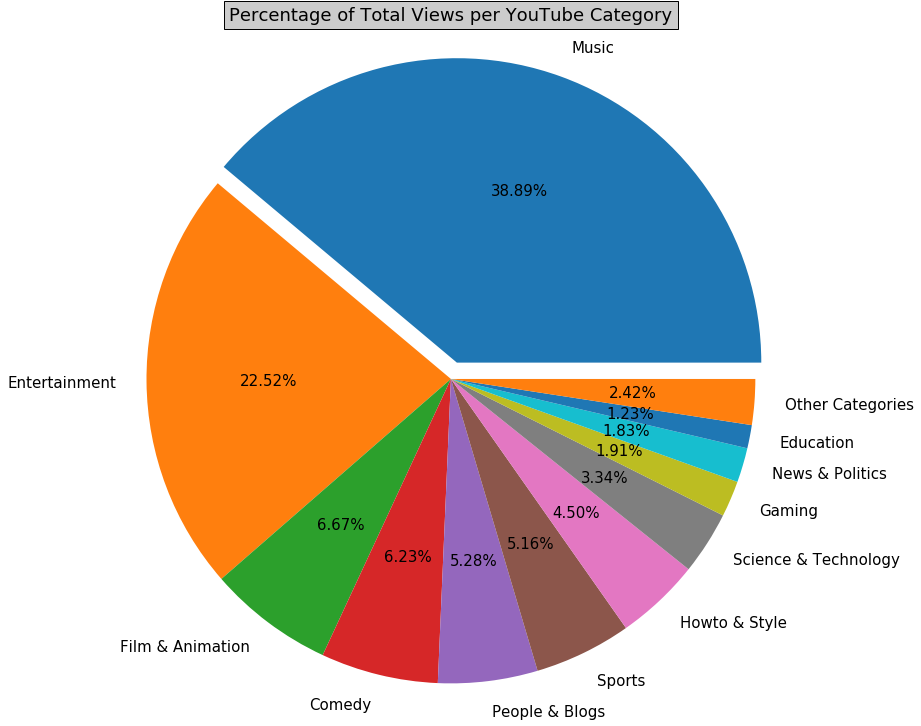

In [5]:
# Key to show what each category id refers to
category_key = {1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 
                17: 'Sports', 19: 'Travel & Events', 20: 'Gaming', 22: 'People & Blogs', 
                23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 
                27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 43: 'Shows'}

# Calculate the number of views per category
category_views = {k:0 for k in yt_videos['category_id']}

# Sum up the total views per category
for index, row in yt_videos.iterrows():
    category_views[row['category_id']] += row['views']

# Sort the categories in descending order by view count
categories_sorted_by_total_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)

total_views = sum(x[1] for x in categories_sorted_by_total_views)

# Only include categories that make up larger than 1 percent of total views
# Combine the other categories that are less than 1 percent into an "Other" category
adjusted_categories_sorted_by_total_views = []
for i in categories_sorted_by_total_views:
    if i[1] / total_views > 0.01:
        adjusted_categories_sorted_by_total_views.append(i)

# Pop out the largest category on the pie chart. Need to add an additional entry for the Other category
explode_lst = [0]*(len(adjusted_categories_sorted_by_total_views)+1)
explode_lst[0] = 0.2

# Extract the view count from the list of tuples
view_count = [x[1] for x in adjusted_categories_sorted_by_total_views]
# Calculate the remaining views for the Other category
view_count.append(total_views-sum(view_count))

# Extract the category id from the list of tuples and convert it to its string representation
categories = [category_key[x[0]] for x in adjusted_categories_sorted_by_total_views]
categories.append('Other Categories')

# Create the Pie Chart
matplotlib.rcParams['font.size'] = 15.0
plt.pie(view_count, labels = categories, explode = explode_lst, autopct = '%.2f%%', radius = 3.5)
plt.title("Percentage of Total Views per YouTube Category", pad=250, bbox={'facecolor':'0.8', 'pad':5})
plt.show()

# Total Number of Trending Videos by Category
I this section, I calculated the number of trending videos per category. 
The Entertainment category has the most trending videos with 25.5% of all trending videos.

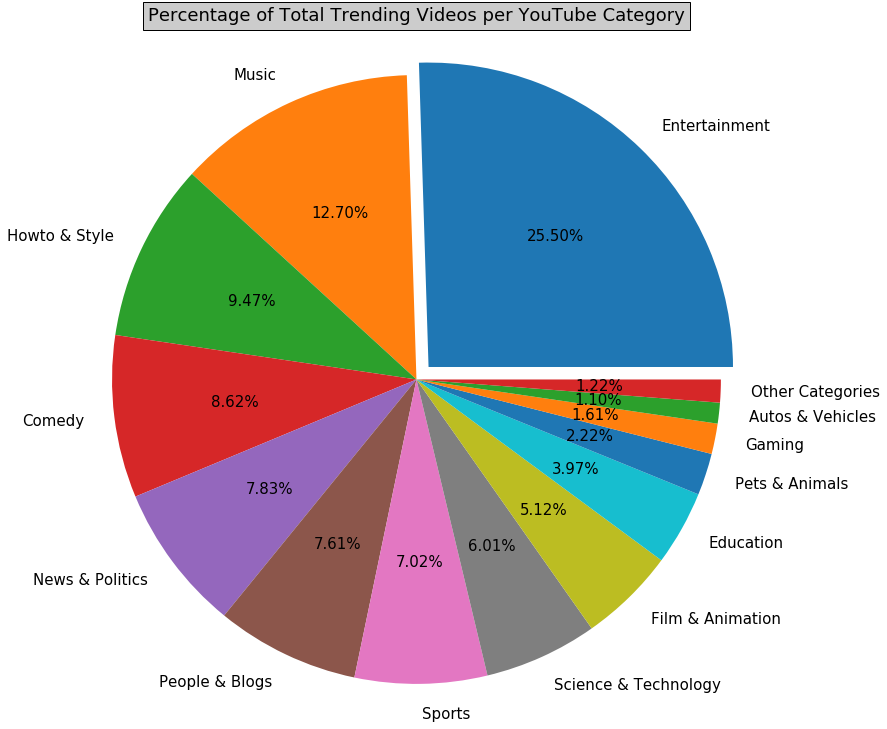

In [6]:
# Calculate the number of uploads per category
category_video_uploads = {k:0 for k in yt_videos['category_id']}

# Count the number of video uploads per category
for index, row in yt_videos.iterrows():
    category_video_uploads[row['category_id']] += 1
    
# Sort the categories in descending order by video upload count
categories_sorted_by_num_uploads = sorted(category_video_uploads.items(), key=lambda x: x[1], reverse=True)

# Only include categories that make up larger than 1 percent of total uploads
# Combine the other categories that are less than 1 percent into an "Other" category
total_uploads = len(yt_videos.index)
adjusted_categories_sorted_by_total_uploads = []

for i in categories_sorted_by_num_uploads:
    if i[1] / total_uploads > 0.01:
        adjusted_categories_sorted_by_total_uploads.append(i)

# Extract the upload count from the list of tuples
upload_count = [x[1] for x in adjusted_categories_sorted_by_total_uploads]
upload_count.append(len(yt_videos.index) - sum(upload_count))

# Extract the category id from the list of tuples and convert it to its string representation
categories = [category_key[x[0]] for x in adjusted_categories_sorted_by_total_uploads]
categories.append('Other Categories')

# Pop out the largest category on the pie chart. Need to add an additional entry for the Other category
explode_lst = [0]*(len(adjusted_categories_sorted_by_total_uploads)+1)
explode_lst[0] = 0.2

# Create the Pie Chart
plt.pie(upload_count, labels = categories, explode = explode_lst, autopct = '%.2f%%', radius = 3.5)
plt.title("Percentage of Total Trending Videos per YouTube Category", pad=250, bbox={'facecolor':'0.8', 'pad':5})
plt.show()  

# Average Video Views per Category
In this section, I wanted to determine which categories had the most views per video on average. I calculated this by dividing the total number of views per category by the number of trending videos per category. 
I found that the Music category has the most views by a significant margin with 6,055,450 average views per video. The second highest category is Film & Animation with just 2,578,967 average views per video.

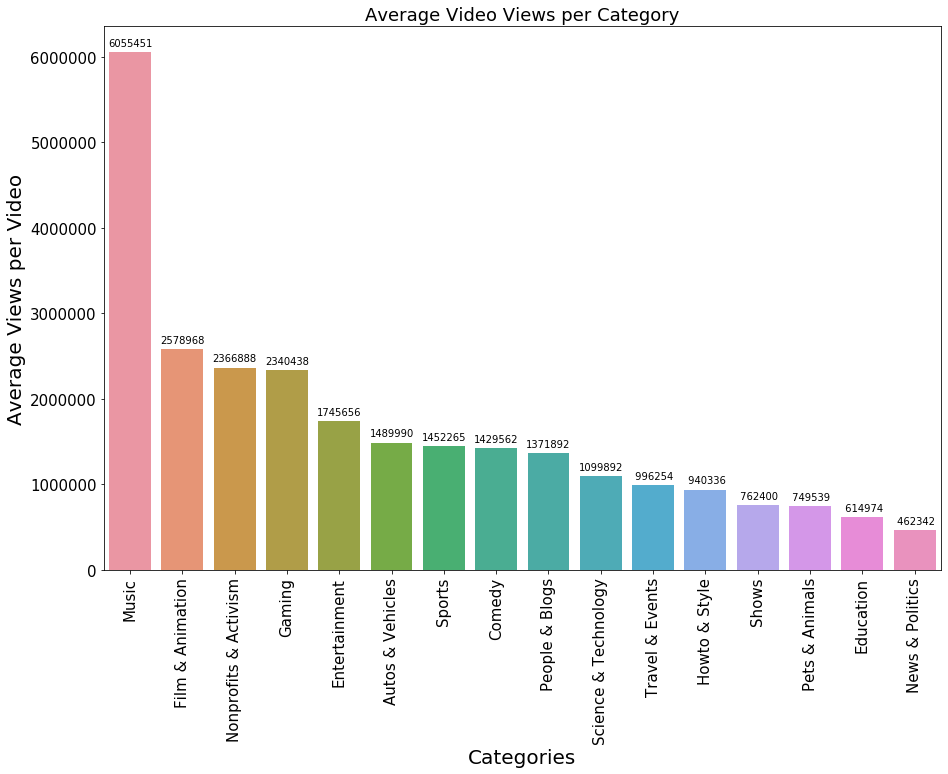

In [7]:
avg_views_per_video_by_category = {k: v / category_video_uploads[k] for k,v in category_views.items() 
                                   if k in category_video_uploads}

# Sort the categories in descending order by average views per video
categories_sorted_by_views_per_video = sorted(avg_views_per_video_by_category.items(), 
                                              key=lambda x: x[1], reverse=True)

# Create a dataframe from the dictionary 
views_df = pd.DataFrame(columns=['category', 'views'])
views_df['category'] = [category_key[x[0]] for x in categories_sorted_by_views_per_video]
views_df['views'] = [x[1] for x in categories_sorted_by_views_per_video]

# Plot the graph
plt.figure(figsize=(15,10))
splot = sns.barplot(x="category",y="views",data=views_df)

# Set the title and axis labels
splot.set_title("Average Video Views per Category")
splot.set_xlabel('Categories',fontsize = 20)
splot.set_ylabel('Average Views per Video',fontsize = 20 )

# Rotate the x labels 90 degrees
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)    

# Add value annotations above each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '7.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   fontsize = 10,
                   textcoords = 'offset points')

# Average Like Ratio per Category
A video's like ratio is an important indicator for user sentiment. In this analysis, I wanted to see if there were certain categories of videos that were more liked than others. I calculated like ratios by summing up the total likes and dislikes for each category and then dividing likes by likes plus dislikes.

I found that most categories were generally liked as most had a like ratio of over 90%. The only two categories with like ratios below 90% are Nonprofits & Activism with a 80.9% like ratio and News & Politics with a 80.1% like ratio.

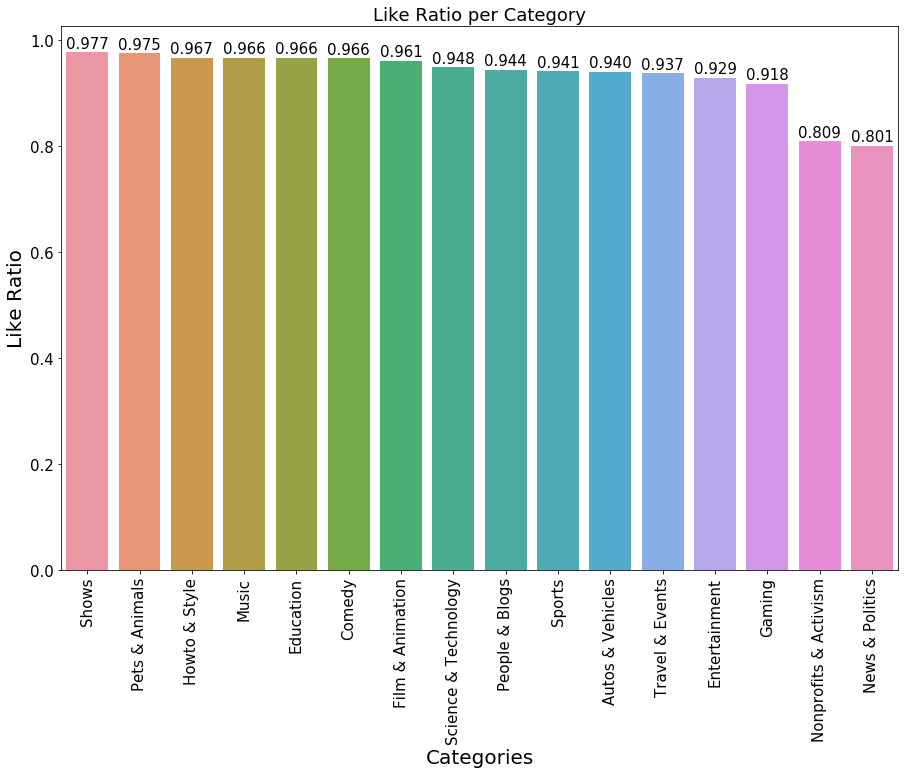

In [8]:
# Add a like ratio column to the dataframe
like_ratio = []
for index, row in yt_videos.iterrows():
    divisor = row['likes'] + row['dislikes']
    
    # Handle instances of no likes and dislikes by setting it equal to -1
    if divisor > 0:
        like_ratio.append(row['likes']/divisor)
    else:
        like_ratio.append(-1)
    
yt_videos['like_ratio'] = like_ratio

# Calculate the average like ratio for each category
like_ratio_by_category = {k: [0,0] for k in yt_videos['category_id']}

# Calculate the like ratio by summing all likes per category and dividing by likes and dislikes
for index, row in yt_videos.iterrows():
    like_ratio_by_category[row['category_id']][0] += row['likes']
    like_ratio_by_category[row['category_id']][1] += row['dislikes'] 
    
for k, v in like_ratio_by_category.items():    
    like_ratio_by_category[k].append(v[0]/(v[0]+v[1]))

# Sort the categories in descending order by average views per video
categories_sorted_by_like_ratio = sorted(like_ratio_by_category.items(), key=lambda x: x[1][2], reverse=True)

# Organize the data for the bar chart into a new dictionary
like_ratio_dict = {category_key[x[0]]:x[1][2] for x in categories_sorted_by_like_ratio}

# Create a dataframe from the dictionary 
like_ratio_df = pd.DataFrame(columns=['category', 'like_ratio'])
like_ratio_df['category'] = [k for k in like_ratio_dict.keys()]
like_ratio_df['like_ratio'] = [v for v in like_ratio_dict.values()]

# Plot the graph
plt.figure(figsize=(15,10))
splot = sns.barplot(x="category",y="like_ratio",data=like_ratio_df)

# Set the title and axis labels
splot.set_title("Like Ratio per Category")
splot.set_xlabel('Categories',fontsize = 20)
splot.set_ylabel('Like Ratio',fontsize = 20 )

# Rotate the x labels 90 degrees
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)    

# Add value annotations above each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


# Time Series Analysis of Views Over Time
Below, I visualized the total number of views on trending videos for each day. This type of data is called a time series and is simply data that is graphed over time in chronological order. Time series data is very important as it is used everywhere from extracting trends in google searches to trying to predict future prices of stocks on the stock market. If you want to know more about time series analyses, I recommend checking out this Investopedia article that I found to be useful: https://www.investopedia.com/terms/t/timeseries.asp. 

The average amount of views for trending videos on any given day is 58,126,592 total views. This is indicated on the chart by the red dashed line. Most days hover roughly around this mean. However, April 20, 2018 stands out from the rest of the days as it had 371,544,490 total trending views that day. This is over six times more views than the average!

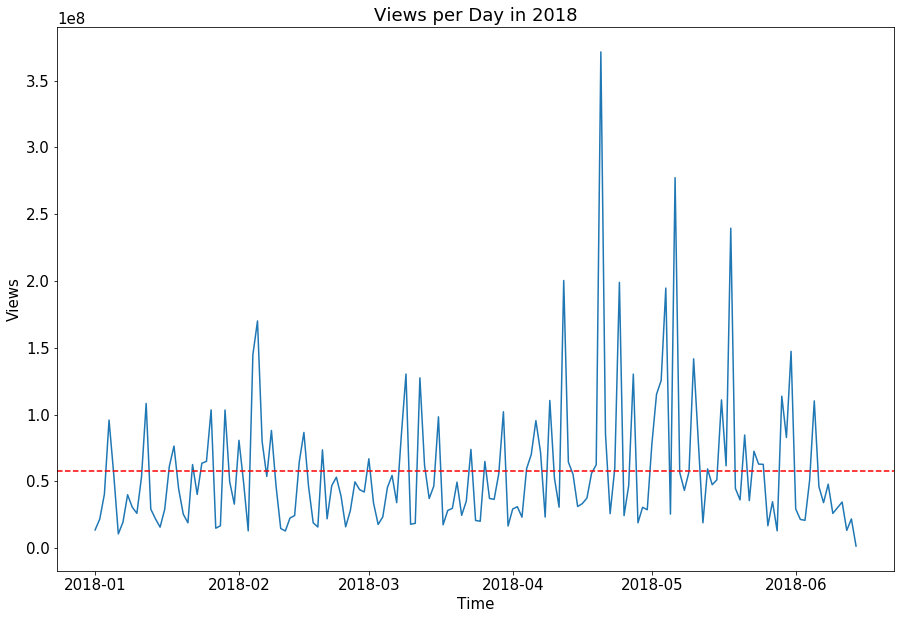

In [9]:
# Create a new column for publish date
publish_date = []

for index, row in yt_videos.iterrows():
    # Extract the date from the date-time object using regex
    date = re.search(r"[0-9]{4}-[0-9]{2}-[0-9]{2}", row['publish_time'])
    publish_date.append(date.group())

# Add the new date column
yt_videos['publish_date'] = publish_date

# Convert the new date column to a datetime object
yt_videos['publish_date'] = pd.to_datetime(yt_videos['publish_date'])

# Sort the dataframe in ascending order by datetime
yt_videos = yt_videos.sort_values(by='publish_date')

views_per_day = {k:0 for k in yt_videos['publish_date']}
cutoff_date = datetime.datetime(2018,1,1)

# Only tally views on days that come on or after January 1, 2018
# This is because most of the data occurs in 2018
for index, row in yt_videos.iterrows():
    if row['publish_date'] >= cutoff_date:
        views_per_day[row['publish_date']] += row['views']

# Only consider views that are greater than zero
dates = [k for k,v in views_per_day.items() if v > 0] 
views = [v for k,v in views_per_day.items() if v > 0] 

# Calculate the max views and average views 
max_views = max(views_per_day, key=views_per_day.get)
mean_views = np.mean(views)

# Draw the Time Series Plot
plt.figure(figsize=(15,10))
plt.plot(dates, views)
# Indicate the average number of views with a horizontal line
plt.axhline(mean_views, color='r', linestyle='dashed')
plt.xlabel("Time")
plt.title("Views per Day in 2018")
plt.ylabel("Views")
plt.show()

I examined the trending videos uploaded on April 20, 2018 to understand why this day stands out over the rest. This was a very eventful day as many popular artists uploaded songs like Ariane Grande's hit "No Tears Left To Cry" and The Chainsmokers "Drew Love". There was also tragic news in the Music industry as the artist Avicii tragically died at age 28 which drew a lot of attention from fans. In addition, the 2018 NBA playoffs were in full swing as the Golden State Warriors faced off against the San Antonio Spurs.

In [10]:
videos_uploaded_on_april_20_2018 = []
for index, row in yt_videos.iterrows():
    if row['publish_date'] == datetime.datetime(2018, 4, 20):
        videos_uploaded_on_april_20_2018.append(row)
new_df = pd.DataFrame(videos_uploaded_on_april_20_2018, columns = yt_videos.columns)
new_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,like_ratio,publish_date
34713,fNVUTgd4pio,2018-05-14,Sugarland - Babe (Static Video) ft. Taylor Swift,SugarlandVEVO,10,2018-04-20T04:00:07.000Z,"Sugarland|""Babe""|""Big""|""Machine""|""Records""|""LL...",4878311,65260,3353,4554,https://i.ytimg.com/vi/fNVUTgd4pio/default.jpg,False,False,False,Music video by Sugarland performing Babe. © 20...,0.951132,2018-04-20
34709,SuzlcQc1iks,2018-05-14,IS IT REAL OR IS IT CHOCOLATE?!,Dobre Brothers,22,2018-04-20T20:51:42.000Z,"Dobre Brothers|""The Dobre Brothers""|""Lucas and...",2960150,56167,16290,11566,https://i.ytimg.com/vi/SuzlcQc1iks/default.jpg,False,False,False,Sponsored by Nimses. Rewarded in Nims. Downloa...,0.775177,2018-04-20
34888,zEf423kYfqk,2018-05-15,"Becky G, Natti Natasha - Sin Pijama (Official ...",BeckyGVEVO,10,2018-04-20T10:40:51.000Z,"Becky G|""Natti Natasha""|""Natti Natasha Music""|...",139334502,1425496,119798,83941,https://i.ytimg.com/vi/zEf423kYfqk/default.jpg,False,False,False,Becky G & Natti Natasha – “Sin Pijama”NUEVO SE...,0.922476,2018-04-20
34889,8Y5-GI9hYcI,2018-05-15,"Abraham Mateo, Yandel, Jennifer Lopez - Se Aca...",AbrahamMateoVEVO,10,2018-04-20T20:00:02.000Z,"Abraham Mateo|""Yandel""|""Jennifer Lopez""|""Pop""|...",29075706,304469,14239,10190,https://i.ytimg.com/vi/8Y5-GI9hYcI/default.jpg,False,False,False,"Music video by Abraham Mateo, Yandel, Jennifer...",0.955323,2018-04-20
34890,bTfJa_Qb5T0,2018-05-15,13 Clever Ways to Fake High-end Looks in Your ...,Hometalk,26,2018-04-20T17:00:04.000Z,"diy|""hometalk""|""home""|""talk""|""howto""|""fakehigh...",5190938,125605,8387,4237,https://i.ytimg.com/vi/bTfJa_Qb5T0/default.jpg,False,False,False,Is having high-end home decor important to you...,0.937407,2018-04-20


# Average Time to Trend
I calculated the average time a video typical takes to become trending after its upload date. On average, videos take eight days to trend after they are uploaded.

In [11]:
# Create a new column for the amount of days it takes for a video to trend since its publish date
yt_videos['time_to_trend'] = yt_videos['trending_date'] - yt_videos['publish_date']
yt_videos['time_to_trend'] = yt_videos['time_to_trend'].dt.days

# Create a new column for the number of tags
number_of_tags = []
for index, row in yt_videos.iterrows():
    number_of_tags.append(len(row['tags'].split("|")))
yt_videos['number_of_tags'] = number_of_tags

# Create a new column for the length of the description
description_length = []
for index, row in yt_videos.iterrows():
    description_length.append(len(row['description']))
yt_videos['description_length'] = description_length

# Only want to sum videos that were released after 11-08-2017 since there are many outliers before this date
trend_cutoff_date = datetime.datetime(2017,11,8)

# Calculate the average trend time but summing time to trend divided by the number of data points
total_time_to_trend = yt_videos.loc[yt_videos['publish_date'] > trend_cutoff_date, 'time_to_trend'].sum()
num_data_points = len(yt_videos[yt_videos['publish_date'] > trend_cutoff_date])

avg_time_to_trend = total_time_to_trend / num_data_points

# Most common time to upload video
I wanted to determine if there were times in the day that were more popular to upload videos. I iterated over my data and counted the number of videos that were uploaded for each of the hours in the day. I found that 4PM UTC was the most popular time to upload which is 11AM EST.

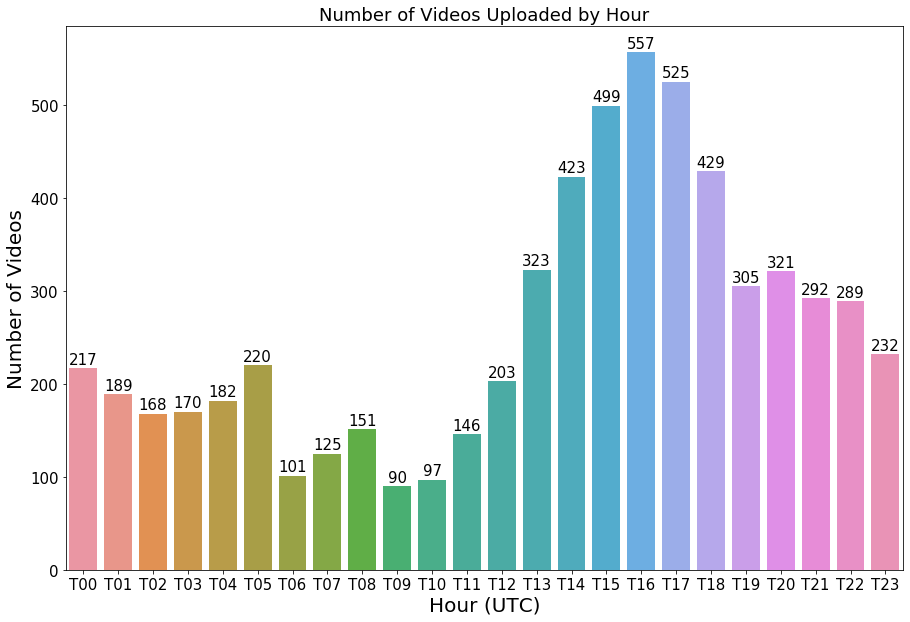

In [12]:
# Create a dictionary of hours ranging from 00 to 23
time_range = pd.date_range('2018-1-01T00:00:00.000Z', '2018-1-01T23:00:00.000Z', freq='H')
times = ["T" + str(re.search(r"\s[0-9]{2}", str(x)).group())[1:] for x in time_range]

upload_time = {k:0 for k in times}

# Count the number of videos that were uploaded per hour
for row in yt_videos['publish_time']:
    time = re.search(r"T[0-9]{2}", row).group()
    upload_time[time] += 1


    
# Create a dataframe from the dictionary 
upload_time_df = pd.DataFrame(columns=['hour', 'video_count'])
upload_time_df['hour'] = [k for k in upload_time.keys()]
upload_time_df['video_count'] = [v for v in upload_time.values()]

# Plot the graph
plt.figure(figsize=(15,10))
splot = sns.barplot(x="hour",y="video_count",data=upload_time_df)

# Set the title and axis labels
splot.set_title("Number of Videos Uploaded by Hour")
splot.set_xlabel('Hour (UTC)',fontsize = 20)
splot.set_ylabel('Number of Videos',fontsize = 20 )

# Rotate the x labels 90 degrees
splot.set_xticklabels(splot.get_xticklabels())    

# Add value annotations above each bar
for p in splot.patches:
    splot.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    

# Model Number of Views with a Multiple Linear Regression
One of the final steps in the data life cycle is the analysis and hypothesis testing phase. A very important question to ask is: "Is there a relationship between video views and other aspects of videos like its category?". I wanted to test this by running a multiple linear regression. 
A multiple linear regression is very similar to a linear regression as it tries to model the linear relationship between the indepent and dependent variables. The only differece is that in a multiple linear regression, you can have more than one independent variable. If you want to know more about multiple linear regressions, I suggest reading this article: https://www.investopedia.com/terms/m/mlr.asp. 
In my multiple linear regression, I tried to model views using the following independent variables: likes, dislikes, comment count, category, and like ratio. Below, I compiled my data into two disjoint sets: training and testing. This is a very common practice in modeling as some models can suffer from over fitting. Over fitting is when a model becomes too sensitive to the training data and ends up performing worse due to noise in the data. This wikipedia article explains the issues with overfitting very well and shows some examples of this: https://en.wikipedia.org/wiki/Overfitting. I choose to use an 80/20 split of training and testing data which is a fairily common ratio to use.

In [13]:
# Split data into an 80/20 split of training and testing data
num_data_points = len(yt_videos.index)

# Use views, likes, dislikes, and comment_count as the features
X_train = yt_videos[['likes', 'dislikes', 'comment_count', 'category_id', 'like_ratio']][:int(0.8*num_data_points)]
y_train = list(yt_videos['views'][:int(0.8*num_data_points)])

X_test = yt_videos[['likes', 'dislikes', 'comment_count', 'category_id', 'like_ratio']][int(0.8*num_data_points):]
y_test = list(yt_videos['views'][int(0.8*num_data_points):])

### Train the Multiple Linear Regression

In [14]:
# Train the model
lin_reg = LinearRegression().fit(X_train, y_train)

# Test and Evaluate the Model's Performance
After the model is trained, I calculated its R squared value. The R squared statistic is a measure of how much of the dependent variable's variance can be explained by the independent variables. This value ranges from 0-1 with 1 being the best score and 0 being the worst. I suggest reading this Investopedia article for more insight on the R squared statistic: https://www.investopedia.com/terms/r/r-squared.asp. My multiple linear regression model has an R squared value of 0.726 which means about 3/4 of the dependent variable's variance is caused by the independent variables. 
In addition to the R squared statistic, I also evaluated my model's performance with a violin graph of the model residuals. A violin graph is a nice and easy way to visualize a distribution of data. I made predictions using the testing set and compared those with the actual values. I compared them by subtracting the actual values from the predicted values which is called a residual value. In a perfect model, the residuals would be zero indicating that there is no difference between a model's prediction and the real life data. The average residual value for my model is 1,167,675. This means that my model was off by about a million views. This may seem bad at first, however, most videos on the trending list have many millions of views and some have upwards of hundreds of millions of views. 
I concluded that there is a relatively strong relationship between a video's views and the following independent variables: likes, dislikes, comment count, category, and like ratio.

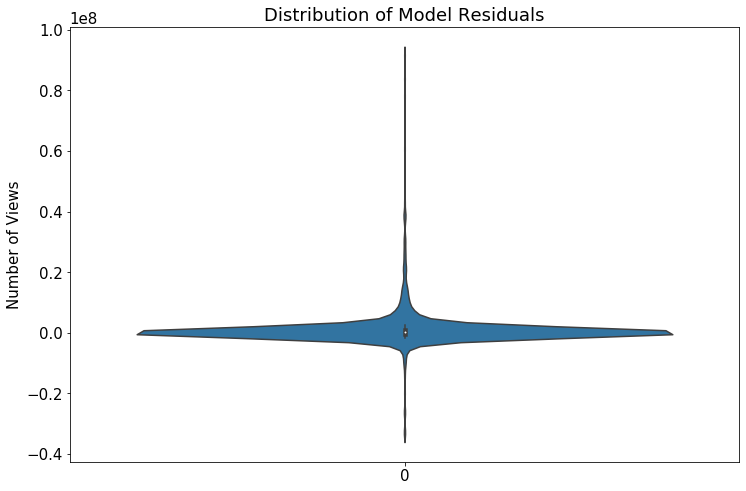

In [15]:
# Get the R squared value
r_squared = lin_reg.score(X_test, y_test)

# Calculate the residual values of the actual vs predicted values
y_pred = lin_reg.predict(X_test)
residuals = y_test - y_pred

# Make the violin plot of the residual values
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.violinplot(data=residuals)
ax.set(title = 'Distribution of Model Residuals')
ax.set(ylabel = 'Number of Views')

# Print descriptive Statistics
df_describe = pd.DataFrame(residuals).describe()

# Conclusion
YouTube today is a bohemoth in the online video space and will continue to hold its number one spot for the foreseeable future. One can find almost anything on YouTube ranging from news and sports to videos of cats playing the piano. It is every YouTuber's dream to eventually make it onto YouTube's trending page as this is an extremely effective way to have your video obtain the most exposure.

Finally, if you want your video to have the best chance at trending, make sure to upload it at 4PM UTC in the Music category and wait about eight days. If you cannot do this, then I suggest that you at least avoid uploading a video at 9AM UTC about News & Politics as this historically is the least viewed and least liked category as well as time to upload.